In [1]:
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pickle
data_path=Path("../Data/DataProcessing/cleaned_food_data.csv")
df = pd.read_csv(data_path)
with open('../Data/DataProcessing/metadata.pkl', 'rb') as f:
    loaded_metadata = pickle.load(f)

numeric_cols = loaded_metadata['numerical_features']

# --- STEP 1: Boolean Encoding ---
boolean_features= loaded_metadata['boolean_features']
for col in boolean_features:
    df[col] = df[col].astype(int)

# --- STEP 2: One-Hot Encoding ---
df = pd.get_dummies(df, columns=loaded_metadata['categorical_features'], prefix=['Meal', 'Prep'],drop_first=False)

# --- STEP 3: Target Label Encoding ---
le = LabelEncoder()
df['Food_Name_Encoded'] = le.fit_transform(df['Food_Name'])
food_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nTarget Mapping:", food_mapping)

# --- STEP 4: Feature Scaling ---
# We do this AFTER clipping so the outliers don't shrink the normal data
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# --- STEP 5: Final Cleanup & Save ---
df_final = df.drop(columns=['Food_Name'])
output_dir = Path('../Data/FeatureEngineering')
output_dir.mkdir(exist_ok=True)
df_final.to_csv('../Data/FeatureEngineering/feature_engineered_data.csv', index=False)

print("\nFeature Engineering with Clipping is Complete!")
print(f"Final dataset shape: {df_final.shape}")


Target Mapping: {'Apple': np.int64(0), 'Banana': np.int64(1), 'Burger': np.int64(2), 'Donut': np.int64(3), 'Ice Cream': np.int64(4), 'Pasta': np.int64(5), 'Pizza': np.int64(6), 'Salad': np.int64(7), 'Steak': np.int64(8), 'Sushi': np.int64(9)}

Feature Engineering with Clipping is Complete!
Final dataset shape: (31387, 22)


In [11]:
columns=df_final.columns.tolist()
columns.remove('Food_Name_Encoded')
print(columns)
print(f"Columns in the final dataset: {len(columns)}")

['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Fiber', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size', 'Is_Vegan', 'Is_Gluten_Free', 'Meal_breakfast', 'Meal_dinner', 'Meal_lunch', 'Meal_snack', 'Prep_baked', 'Prep_fried', 'Prep_grilled', 'Prep_raw']
Columns in the final dataset: 21


## Phase 1: Feature Selection
Adding feature selection techniques

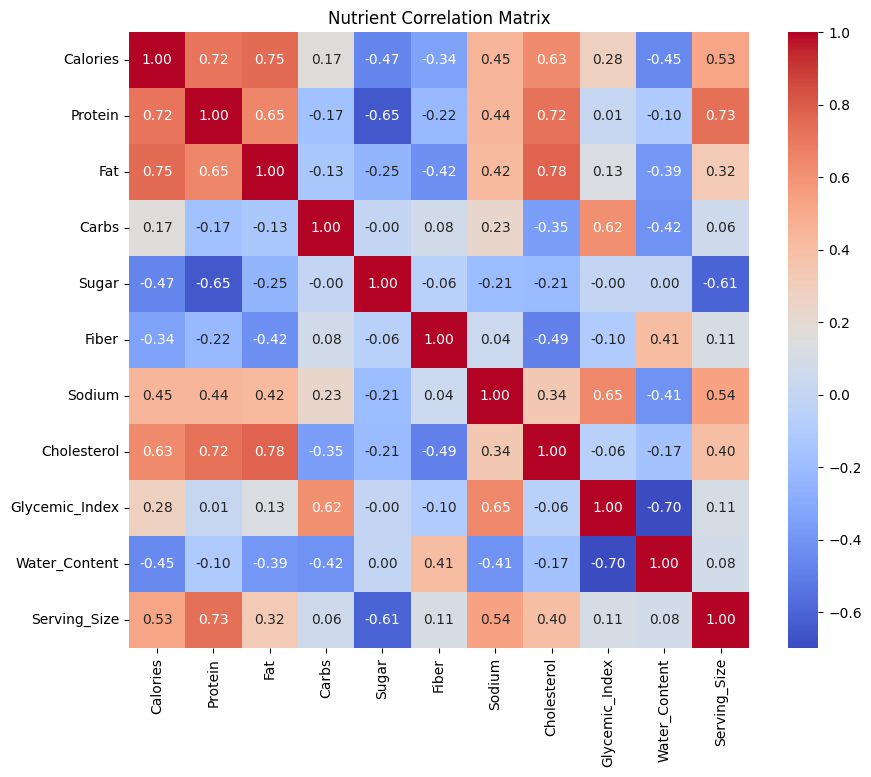

In [4]:
# Assuming 'df' is your cleaned numeric dataframe
corr_matrix = df_final[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Nutrient Correlation Matrix")
plt.show()


In [5]:
def remove_highly_correlated_features(df, threshold=0.90):
    # Calculate absolute correlation matrix
    corr_matrix = df.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping redundant features: {to_drop}")
    return df.drop(columns=to_drop), to_drop

# Apply the function
df_reduced, dropped_cols = remove_highly_correlated_features(df[numeric_cols])


Dropping redundant features: []


In [6]:
from sklearn.feature_selection import SelectKBest, f_classif

# Encode your target 'y' (e.g., Food_Name or Meal_Type) first
# Select top 5 features based on their statistical relationship with the target
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(df_final[numeric_cols], df_final['Food_Name_Encoded'])

selected_features = df_final[numeric_cols].columns[selector.get_support()]
print(f"Most important features for predicting target: {list(selected_features)}")


Most important features for predicting target: ['Calories', 'Protein', 'Fat', 'Carbs', 'Sugar', 'Sodium', 'Cholesterol', 'Glycemic_Index', 'Water_Content', 'Serving_Size']


In [12]:
metadata={
    'class_labels': food_mapping,
    'classes': le.classes_.tolist(),
    'selected_features': columns,
    'trained_scaler': scaler,
    'label_encoder': le
}
with open('../Data/FeatureEngineering/feature_engineering_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)